Let's start with importing necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import json
import tensorflow as tf
import unicodedata
import re
import os
# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
# sickit learning 
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
#from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
#from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, ShuffleSplit, RepeatedStratifiedKFold, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
# settings
#sns.color_palette("rocket_r", as_cmap=True)
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
np.random.seed(42)
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../input/alldialectdataset/out.csv", encoding="utf-8", lineterminator='\n')
df.drop(columns=["id"], inplace=True)
df.columns = ['dialect', 'tweets']
df.dropna(inplace=True)

## `Clean Text` 
Next step to try several preprocessing methods **one at a time** to clean our tweets like:-

        * Select arabic characters only from text
        * Remove username "@handle" from text
        * Remove URL from text
        * Remove punctuation, emoji and smileys from text
        * Remove \n, \t ,,, etc from text
        * Remove Diacritization from text
        * Remove Arabic Stop Words from text
        
> Only  removing Diacritization and Escape Codes makes a slightly improvment in score.

In [3]:
from nltk.corpus import stopwords
nltk_stopwords = stopwords.words('arabic')
nltk_stopwords[:10]

['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي']

In [4]:
def remove_stop_words(text):
    words = [word for word in text.split() if word not in nltk_stopwords]
    return " ".join(words)    

> Preprocessing Pipeline

In [5]:
def clean_text(text):
    ##text = ' '.join(re.findall(r'[\u0600-\u06FF]+', text)) # Select arabic characters only from text
    ###text = re.sub(r'(@.*?)[\s]', ' ', text) # Remove username "@handle"
    ##text = re.compile(r'https?://\S+|www\.\S+').sub(r'', text) # Remove username "@handle"
    ##text = re.sub(r'[^\w\s]', '', text) # Remove punctuation, emoji and smileys
    text = re.sub(r'\s+', ' ', text).strip()  # Remove Escape Codes
    text = re.sub(re.compile(r'[\u0617-\u061A\u064B-\u0652]'),"", text) # Remove Diacritizations
    #text = remove_stop_words(text)
    text = text.strip() 
    return text

df['clean_tweets'] = df.tweets.apply(lambda t: clean_text(t))

In [6]:
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['dialect_encode'] = le.fit_transform( df['dialect'] ).astype(np.int8)
target_names = le.inverse_transform(np.arange(18))
target_names

array(['AE', 'BH', 'DZ', 'EG', 'IQ', 'JO', 'KW', 'LB', 'LY', 'MA', 'OM',
       'PL', 'QA', 'SA', 'SD', 'SY', 'TN', 'YE'], dtype=object)

![](https://miro.medium.com/max/1200/1*3-KkZ0hlRZxjMn7Z6uXDGg.png)

In [7]:
#X = df.tweets#clean_tweets#.values
X = df.clean_tweets.values
y = df.dialect_encode.values
y = np.array(y).reshape((-1,1)).ravel()

In [8]:
# The train val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.7, shuffle=True, random_state = 42)

In [9]:
n_estimators = 10

In [10]:
def text_pipeline(clf):
    return Pipeline([
        ('vect', CountVectorizer()), # , tokenizer=clean_text
        ('tfidf', TfidfTransformer()),
        ('clf', OneVsRestClassifier(clf, n_jobs=-1))
    ])

In [11]:
clfs = {
    'LinearSVC': LinearSVC(),
    'LogisticRegression': LogisticRegression(C=5, solver='newton-cg', max_iter=1000, multi_class='ovr'),
    #'SGDClassifier': SGDClassifier(loss='epsilon_insensitive', penalty='l2',alpha=0.0001, random_state=42), 
}

In [12]:
results = {}
for classifier_name, clf in clfs.items(): 
    text_clf  = text_pipeline(clf)
    text_clf.fit(X_train, y_train)
    predicted = text_clf.predict(X_val)
    # model accuracy: the total ratio of tp/(tp + fp)
    score = precision_score(predicted, y_val, average='micro') #np.mean(predicted == y_val)
    #print(classifier_name, score)
    
    results[classifier_name] = {
        "score" : score,
        "confusion_matrix": confusion_matrix(y_val, predicted),
        "classification_report": classification_report(
            predicted, 
            y_val,
            target_names = target_names, 
            digits=2,
            output_dict=True
        ),
    }

### Scores
`LinearSVC`
> 0.658

`Logistic Regression`
> 0.636

`SGD Classifier`
> 0.617

In [13]:
for classifier_name, clf in clfs.items(): 
    print(classifier_name, round(results[classifier_name]['score'], 3))

LinearSVC 0.658
LogisticRegression 0.636


`Confusion Matrix`

[None, None]

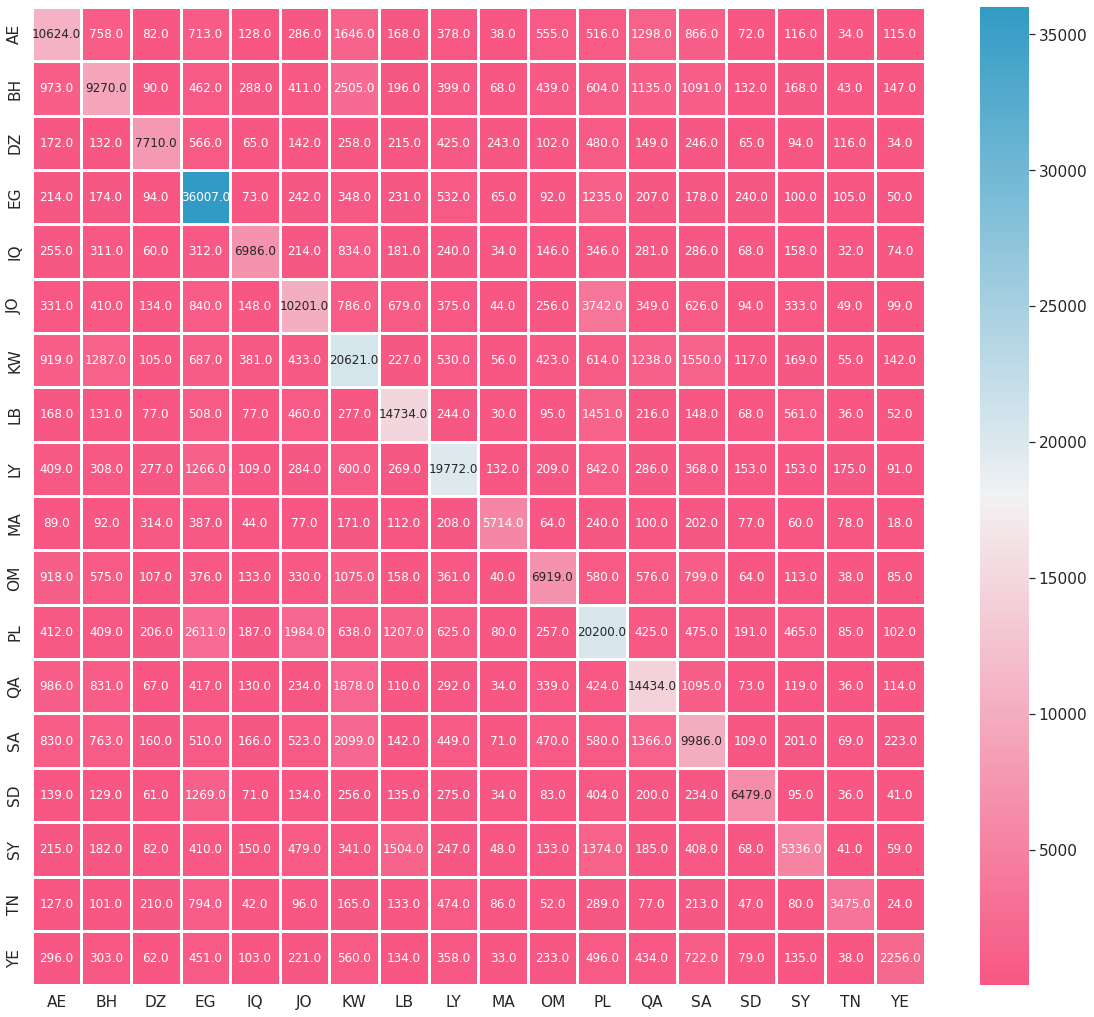

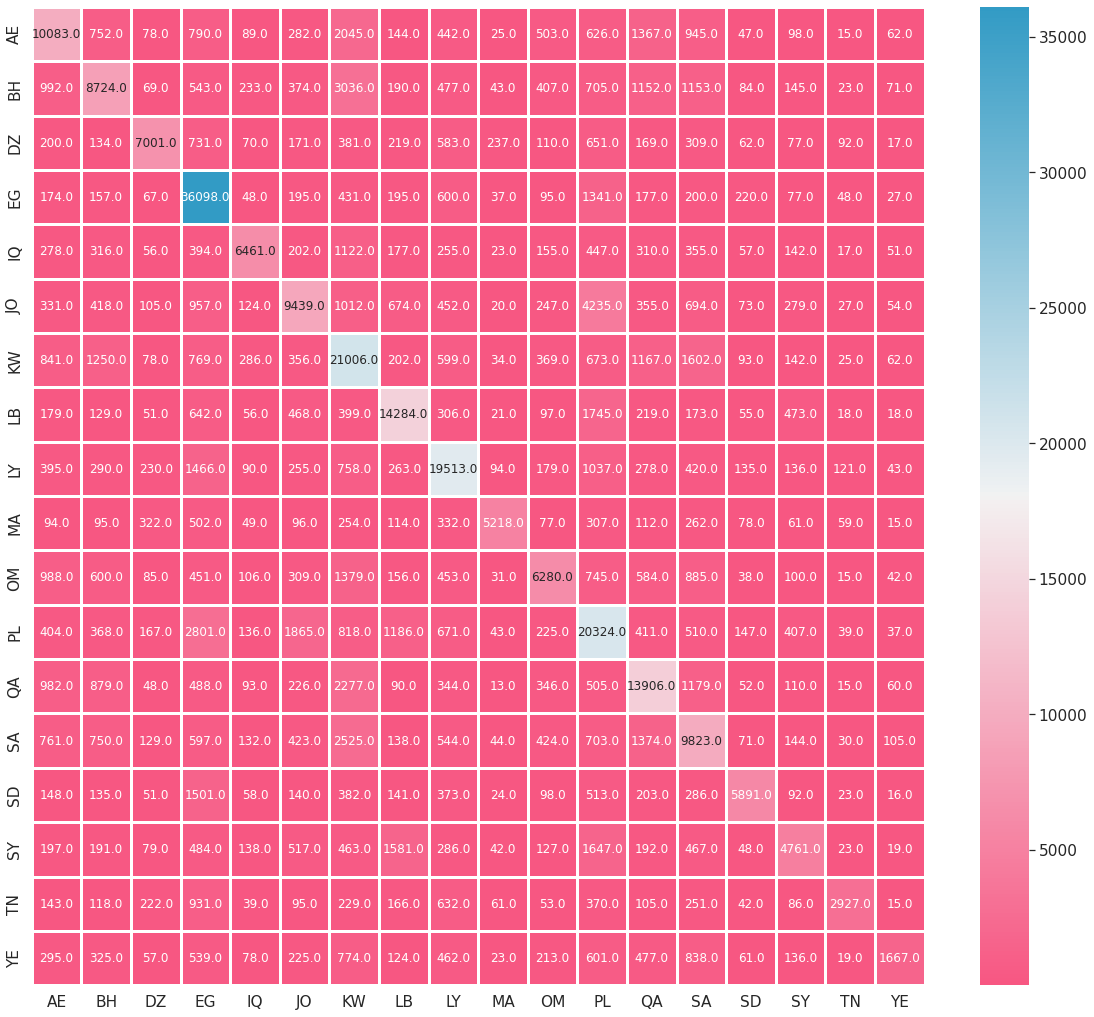

In [14]:
def ConfusionMatrix(cm):
    #cm = confusion_matrix(y_val, predicted)
    df_cm = pd.DataFrame(cm, target_names, target_names)

    plt.figure(figsize = (20, 18))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(
        df_cm,
        fmt=".1f", annot=True, annot_kws={'size': 12}, cmap=cmap,
        linewidths=3,
    );
    return None
    
display([
    ConfusionMatrix(results['LinearSVC']['confusion_matrix']), 
    ConfusionMatrix(results['LogisticRegression']['confusion_matrix']),
    #ConfusionMatrix(results['SGDClassifier']['confusion_matrix'])
])

## Notices from Confusion Matrix
Let's focus in high misclassification ratio happens for each dialect:- 

    - `AE` :  SA, KW, BH
    - `BH` :  AE, KW, OM, SA, QA
    - `DZ` :  MA, TN, LY
    - `EG` :  LY, PL, SD
    - `IQ` :  KW, BH
    - `JO` :  PL, LB, SY
    - `KW` :  BH, AE, QA, SA
    - `LB` :  PL, SY
    - `LY` :  EG, KW, PL, TN
    - `MA` :  DZ, LY
    - `OM` :  AE, BH, KW, QA, SA
    - `PL` :  JO, EG, LB, LY, SY
    - `QA` :  SA, KW, AE, BH
    - `SA` :  QA`, KW, BH, AE
    - `SD` :  EG, LY, PL
    - `SY` :  LB, PL
    - `TN` :  LY, DZ
    - `YE` :  SA
    
    
    
`Most of misclassifications happens for each dialect with dialects for share border countries. So we can break a classifier into three to five classifiers. each classifier for a group of share border countries like:-`

    - ['QA', 'SA', 'AE', 'KW', 'OM', 'YE','BH']
    - ['LY', 'SY', 'JO', 'PL', 'IQ']
    - ['EG', 'LY', 'SD']
    - ['TN', 'MA', 'DZ']

By breaking down accuracy scores to individual classes. If a model has higher accuracy scores for some classes than another model and vice versa we can use `Voting Classifier` to get a better overall accuracy. 

In [15]:
def breakdown_scores(matrix, pres):
    all_scores = pd.DataFrame()
    for i, matrix in enumerate(matrix):
        matrix = matrix.diagonal() / matrix.sum(axis=1)
        all_scores = pd.concat([
            all_scores, 
            pd.DataFrame({'Dialect': target_names, 'scores': matrix})
        ], axis=1)#.add_prefix(pres[i])
    return all_scores#.sort_values(by=['scores'], ascending=False)

In [16]:
breakdown_scores(
    [
        results['LinearSVC']['confusion_matrix'],
        results['LogisticRegression']['confusion_matrix'],
        #results['SGDClassifier']['confusion_matrix']
    ],
    ['svc_', 'log_'] #, 'sgd_'
    
)

,Dialect,scores,Dialect,scores
0,AE,0.577611,AE,0.548198
1,BH,0.503230,BH,0.473590
2,DZ,0.687533,DZ,0.624309
3,EG,0.895986,EG,0.898251
4,IQ,0.645776,IQ,0.597245
5,JO,0.523236,JO,0.484151
6,KW,0.697740,KW,0.710767
7,LB,0.762117,LB,0.738840
8,LY,0.769249,LY,0.759172
9,MA,0.710078,MA,0.648440


`Precision-Recall` is a useful measure of success of prediction when the classes are very imbalanced. 
In information retrieval, `precision` is a measure of result relevancy, while `recall` is a measure of how many truly relevant results are returned.

In [17]:
def Report(rp):
    report = pd.DataFrame(rp).T
    report['support'] = report.support.apply(int)
    return report
    
pd.concat([
    Report(results['LinearSVC']['classification_report']).add_prefix('svc_'),
    Report(results['LogisticRegression']['classification_report']).add_prefix('log_'), 
    #Report(results['SGDClassifier']['classification_report']).add_prefix('sgd_'),
], axis=1)

,svc_precision,svc_recall,svc_f1-score,svc_support,log_precision,log_recall,log_f1-score,log_support
AE,0.577611,0.587708,0.582616,18077,0.548198,0.576666,0.562071,17485
BH,0.503230,0.573426,0.536040,16166,0.473590,0.558122,0.512393,15631
DZ,0.687533,0.778945,0.730390,9898,0.624309,0.787071,0.696305,8895
EG,0.895986,0.741098,0.811215,48586,0.898251,0.712217,0.794489,50684
IQ,0.645776,0.752721,0.695159,9281,0.597245,0.779749,0.676403,8286
JO,0.523236,0.608979,0.562860,16751,0.484151,0.603594,0.537314,15638
KW,0.697740,0.588197,0.638302,35058,0.710767,0.534626,0.610240,39291
LB,0.762117,0.717507,0.739139,20535,0.738840,0.712632,0.725500,20044
LY,0.769249,0.755118,0.762118,26184,0.759172,0.714134,0.735965,27324
MA,0.710078,0.834161,0.767134,6850,0.648440,0.864910,0.741193,6033


![](https://miro.medium.com/max/1200/1*3-KkZ0hlRZxjMn7Z6uXDGg.png)

# OverSampling
By viewing the percentage of each dialect in the dataset is shows that it's imbalanced.
    - EG dialect has  balance a datase 12.6%
    - AE dialect has  balance a datase 5.74%
    - TN dialect has  balance a datase 12.5%

Trying to improve the performance of ML models we can use `Oversampling`.

`Oversampling` is a technique which increases the number of samples of the smallest class up to the size of the biggest class. This is done by generating synthetic samples.

In [18]:
#from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

X = TfidfVectorizer().fit_transform(df['clean_tweets'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.7, shuffle=True, random_state = 42)
X_train, y_train = RandomOverSampler(random_state=42).fit_resample(X_train, y_train)

OverSampler_results = {}
for classifier_name, text_clf in clfs.items(): 
    text_clf.fit(X_train, y_train)
    predicted = text_clf.predict(X_val)
    score = precision_score(predicted, y_val, average='micro')
    OverSampler_results[classifier_name] = {
        "score" : score,
        "confusion_matrix": confusion_matrix(y_val, predicted),
        "classification_report": classification_report(
            predicted, 
            y_val,
            target_names = target_names, 
            digits=2,
            output_dict=True
        ),
    }

### Scores after using OverSampling
`LinearSVC`
> 0.653

`logisticregresion`
> 0.641

`SGD Classifier`
> 0.617

In [19]:
for classifier_name, clf in clfs.items(): 
    print(classifier_name, round(OverSampler_results[classifier_name]['score'], 3))

LinearSVC 0.653
LogisticRegression 0.641


![](https://miro.medium.com/max/1200/1*3-KkZ0hlRZxjMn7Z6uXDGg.png)

### Last Model

Unlike linearsvm, LogisticRegression has a pridect_prop function and since their accuracy scores are close, we choose
LogisticRegression model with multi_class parameter to 'ovr' which use One Vs Rest technique.

Let's starting with using TfidfVectorizer followed by oversampling method then training chosen model.

In [20]:
model = LogisticRegression(C=5, solver='newton-cg', max_iter=1000, multi_class='ovr')
model.fit(X_train, y_train)
predicted = text_clf.predict(X_val)
precision_score(predicted, y_val, average='micro')

0.6410520000749911

In [21]:
breakdown_scores([confusion_matrix(y_val, predicted)], pres=['']).sort_values(by=['scores'], ascending=False)

,Dialect,scores
3,EG,0.856770
8,LY,0.747812
7,LB,0.743030
9,MA,0.699888
2,DZ,0.674157
14,SD,0.659156
6,KW,0.654463
4,IQ,0.653356
12,QA,0.632305
11,PL,0.616872


### OverSampling makes an improvment to dailects with smaller amount texts like `YE`

![](https://miro.medium.com/max/1200/1*3-KkZ0hlRZxjMn7Z6uXDGg.png)

# `Save Model`
Using `pickle` package to save our trained model for local deployment.

In [22]:
import pickle

# save the model to disk
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))